# Assignment 1

Contents:

- [x] Setup
- [x] Data
    - [x] Preparing the SVHN dataset
    - [x] Visualization of images
- [ ] Training and evaluation of an MLP Classifier
    - [x] Building the MLP model
    - [ ] Training and evaluation
    - [ ] Visualization of predictions
    - [ ] Visualization of performance
        - [ ] Loss plots
        - [ ] Classification accuracy plots
        - [ ] Confusion matrix
    - [ ] Visualization of statistics of the gradients for some parameters during training
- [ ] Hyperparameter optimization
    - [ ] Use *Optuna* to optimize (at least) two hyper-parameters (e.g, number of layers or hidden dimension)
    - [ ] Show some nice optimization plots :)
    - [ ] Discuss: What parameters seem more important? What values are reasonable?
- [ ] **Extra Point**
    - [ ] Train and evaluate a shallow [MLP-Mixer](https://openreview.net/pdf?id=EI2KOXKdnP) model
    - [ ] Compare it with the best MLP model from before. Does it work better? Why or why not?

## Setup

### Modules

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv
from tqdm import tqdm
import optuna

### Paths

In [2]:
PATH_CWD = "."
DIR_DATA = "data"
DIR_DATASET = "svhn"

path_cwd = Path(PATH_CWD)
path_dir_dataset = path_cwd / DIR_DATA / DIR_DATASET

### Config

In [3]:
BATCH_SIZE = 64
SHUFFLE_TRAIN = True
SHUFFLE_TEST = False
NUM_WORKERS_DATALOADING = 4
NUM_EPOCHS = 10
LR = 1e-3
DIMS_HIDDEN = [256]
LAYER_NORM = torch.nn.BatchNorm1d
LAYER_ACTIVATION = torch.nn.ReLU
USE_BIAS = True
PROB_DROPOUT = 0.2

## Data

### Preparing the SVHN dataset

In [4]:
dataset_train = tv.datasets.SVHN(root=path_dir_dataset, split="train", transform=tv.transforms.ToTensor(), download=True)
dataset_test = tv.datasets.SVHN(root=path_dir_dataset, split="test", transform=tv.transforms.ToTensor(), download=True)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN, num_workers=NUM_WORKERS_DATALOADING)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TEST, num_workers=NUM_WORKERS_DATALOADING)

print("Training dataset")
print(f"    {"Length":<10}: {len(dataset_train)}")
print(f"    {"Batches":<10}: {len(dataloader_train)}")
print("Test dataset")
print(f"    {"Length":<10}: {len(dataset_train)}")
print(f"    {"Batches":<10}: {len(dataloader_train)}")

Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training dataset
    Length    : 73257
    Batches   : 1145
Test dataset
    Length    : 73257
    Batches   : 1145


### Visualization of images

In [5]:
def sample(dataset, indices):
    """Sample indexed items from dataset by converting list of tuples of k elements into k separate lists."""
    lists = map(list, zip(*[dataset[i] for i in indices]))
    return lists

In [6]:
num_samples = 17
indices = np.random.randint(low=0, high=len(dataset_train), size=num_samples)
list_images, list_labels = sample(dataset_train, indices)
images = torch.stack(list_images)
labels = torch.as_tensor(list_labels)

print(f"Shape of dataset sample: {images.shape}")
print(f"Labels: {labels}")

Shape of dataset sample: torch.Size([17, 3, 32, 32])
Labels: tensor([9, 5, 0, 6, 3, 4, 0, 3, 6, 1, 3, 2, 2, 2, 4, 0, 4])


In [7]:
def visualize_images(images, labels=None, indices=None):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_image(i):
        ax = plt.gca()

        if labels is not None or indices is not None:
            title = ""
            if indices is not None:
                title += rf"#${indices[i]}$"
            if indices is not None and labels is not None:
                title += " | "
            if labels is not None:
                title += rf"label: {labels[i]}"
            ax.set_title(title, fontsize=9)
        ax.set_axis_off()

        ax.imshow(images[i])

    # Assume same shape for all images
    aspect_images = images[0].shape[1] / images[0].shape[0]
    figsize = fig.get_size_inches()
    aspect_figure = figsize[1] / figsize[0]

    num_subplots = len(images)
    num_rows = max(int(np.sqrt(num_subplots) * aspect_figure / aspect_images), 1)
    num_cols = np.ceil(num_subplots / num_rows).astype(int)
    for i in range(num_subplots):
        fig.add_subplot(num_rows, num_cols, i + 1)
        subplot_image(i)

    plt.tight_layout()
    plt.show()

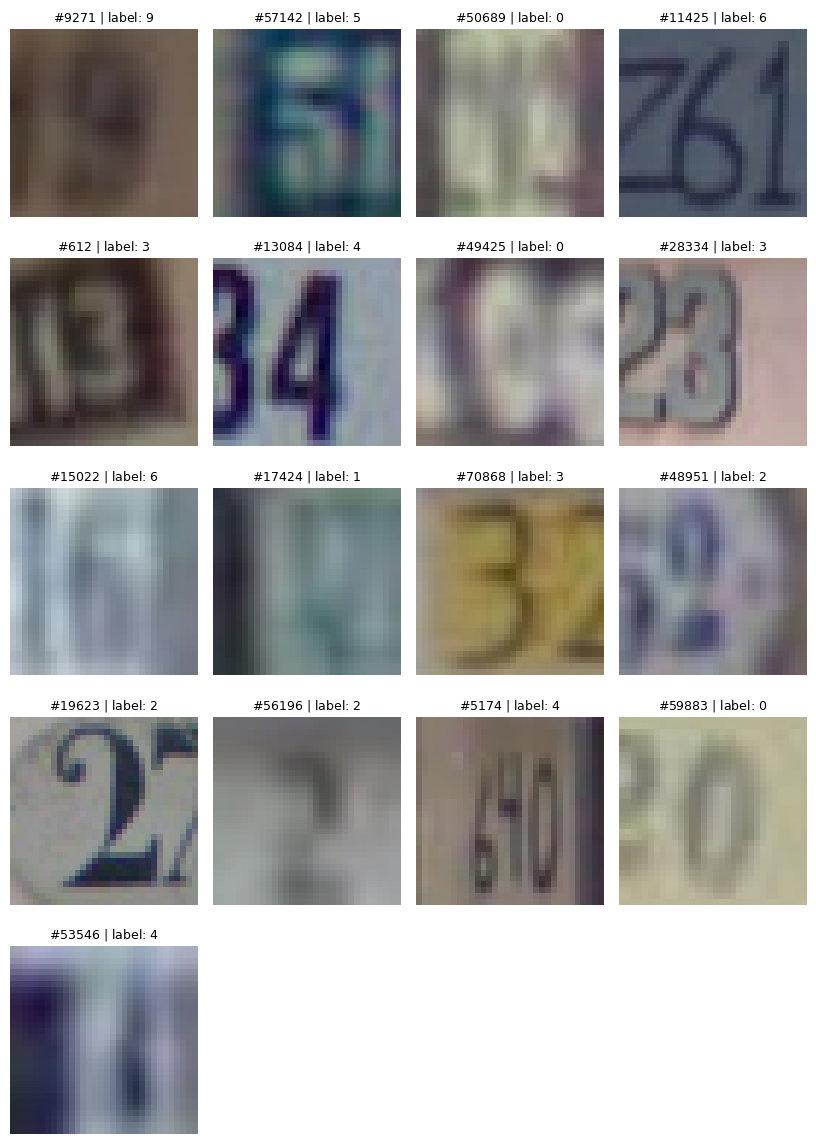

In [8]:
visualize_images(images.permute(0, 2, 3, 1), labels=labels, indices=indices)

## Training and evaluation of an MLP Classifier

### Building the MLP model

In [9]:
class MLP(torch.nn.Module):
    def __init__(
        self,
        dim_input,
        dims_hidden,
        dim_output,
        layer_norm=None,
        layer_activation=torch.nn.ReLU,
        inplace=None,
        bias=True,
        dropout=None,
    ):
        super().__init__()

        kwargs_inplace = {} if inplace is None else {"inplace": inplace}
        dims = [dim_input] + dims_hidden + [dim_output]

        list_layers = []
        for dim_in, dim_out in zip(dims[:-2], dims[1:-1]):
            list_layers.append(torch.nn.Linear(dim_in, dim_out, bias=bias))
            if layer_norm is not None:
                list_layers.append(layer_norm(dim_out))
            list_layers.append(layer_activation(**kwargs_inplace))
            if dropout is not None:
                list_layers.append(torch.nn.Dropout(dropout, **kwargs_inplace))
        list_layers.append(torch.nn.Linear(dims[-2], dims[-1], bias=bias))

        self.layers = torch.nn.Sequential(*list_layers)

    def forward(self, x):
        prediction = self.layers(x)
        return prediction

In [10]:
dim_input = np.prod(np.asarray(dataset_train.data.shape[1:]))
labelset = np.unique(dataset_test.labels)

model = MLP(
    dim_input=dim_input,
    dims_hidden=DIMS_HIDDEN,
    dim_output=labelset.size,
    layer_norm=LAYER_NORM,
    layer_activation=LAYER_ACTIVATION,
    bias=USE_BIAS,
    dropout=PROB_DROPOUT,
)

print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [12]:
def count_model_params(model):
    """Counting the number of learnable parameters in a torch.nn.Module"""
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [13]:
num_params = count_model_params(model)

print(f"Number of parameters: {num_params}")

Number of parameters: 789770


### Training and evaluation

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(device)

cuda


In [ ]:
# Includes softmax
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [10]:
def train(dataloader):
    losses = []

    for epoch in range(NUM_EPOCHS):
        progress_bar = tqdm(dataloader, total=len(dataloader))
        for i, (features, targets) in enumerate(progress_bar):
            features = features.to(device)
            targets = targets.to(device)

            flattened_imgs = imgs.flatten(start_dim=1)
            preds = model(flattened_imgs)

            loss = criterion(preds, labels)
            losses.append(loss.item())

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if i % 10 == 0 or i == len(dataloader) - 1:
                progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

        return losses

  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 1 Iter 1145: loss 2.24936. : 100%|██████████| 1145/1145 [00:03<00:00, 338.77it/s]


In [ ]:
losses = train(dataloader_train)

In [ ]:
model.eval()
model.to(device)

eval_metrics = {}

    with torch.no_grad():
        if suppress_output:
            progress_bar = enumerate(dataset)
        else:
            progress_bar = tqdm(enumerate(dataset), total=len(dataset))
            progress_bar.set_description(f'Evaluation:')
        outputs = []
        targets = []
        for i, (imgs, labels) in progress_bar:
            
            labels_raw = torch.clone(labels)
            imgs, labels = imgs.to(device), labels.to(device)

            imgs, labels = apply_data_preprocessing(imgs, labels, config)

            imgs, labels = imgs.float(), labels.float()

            output = model(imgs).float()

            outputs.append(output.cpu())
            targets.append(labels_raw.cpu())
        
        for eval_metric in config['evaluation']['metrics']:
            func_name = '_evaluation_' + eval_metric
            try:
                eval_metrics[eval_metric] = globals()[func_name](torch.stack(outputs, dim=0), torch.stack(targets, dim=0), config)
            except:
                print(f"NotImplemented: Evaluation metric {eval_metric}")
    return eval_metrics

In [ ]:
n_correct = 0

with torch.no_grad():
    progress_bar = tqdm(enumerate(dataloader_test), total=len(dataloader_test))
    for i, (imgs, labels) in progress_bar:
        imgs = imgs.to(device)
        labels = labels.to(device)

        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)

        pred_labels = torch.argmax(preds, dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct

accuracy = n_correct / len(dataset_test) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

### Visualization of predictions

In [ ]:
flattened_imgs = imgs.flatten(start_dim=1)
output = model(flattened_imgs)

num_samples = 17
indices = np.random.randint(low=0, high=len(dataset_train), size=num_samples)
list_images, list_labels = sample(dataset_train, indices)
images = torch.stack(list_images)
labels = torch.as_tensor(list_labels)

print(f"Shape of dataset sample: {images.shape}")
print(f"Labels: {labels}")

visualize_images(images.permute(0, 2, 3, 1), labels=labels, indices=indices)

### Visualization of performance

#### Loss plots

#### Classification accuracy plots

#### Confusion matrix

### Visualization of statistics of the gradients for some parameters during training

In [ ]:
class GradientInspector:
    STATS = ["Min", "Max", "Mean", "MeanAbs", "Var", "Norm"]
    FUNCS = {
        "Min": torch.min,
        "Max": torch.max,
        "Mean": torch.mean,
        "MeanAbs": lambda x: x.abs().mean(),
        "Var": torch.var,
        "Norm": torch.norm,
    }

    def __init__(self, writer, layers, names, stats=None):
        """Module initializer"""
        stats = stats if stats is not None else GradientInspector.STATS
        for stat in stats:
            assert stat in GradientInspector.STATS, f"{stat = } not included in {self.STATS = }"
        assert isinstance(layers, list), f"Layers is not list, but {type(layers)}..."
        assert len(layers) == len(names), f"{len(layers) = } and {len(names) = } must be the same..."
        for layer in layers:
            assert isinstance(layer, torch.nn.Module), f"Layer is not nn.Module, but {type(layer)}..."
            assert hasattr(layer, "weight"), "Layer does not have attribute 'weight'"

        self.writer = writer
        self.layers = layers
        self.names = names
        self.stats = stats

        print("Initializing Gradient-Inspector:")
        print(f"  --> Tracking stats {stats} of gradients in the following layers")
        for name, layer in zip(names, layers):
            print(f"    --> {name}: {layer}")
        return

    def __call__(self, step):
        """Computing gradient stats and logging into Tensorboard"""
        for layer, name in zip(self.layers, self.names):
            grad = layer.weight.grad
            for stat in self.stats:
                func = self.FUNCS[stat]
                self.writer.add_scalar(f"Grad Stats {name}/{stat} Grad", func(grad).item(), step)
        return

How do these change?

> 

In [11]:
def smooth(f, K=5):
    """Smoothing a function using a low-pass filter (mean) of size K"""
    kernel = np.ones(K) / K
    f = np.concatenate([f[: int(K // 2)], f, f[int(-K // 2) :]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K // 2 : -K // 2]  # removing boundary-fixes
    return smooth_f

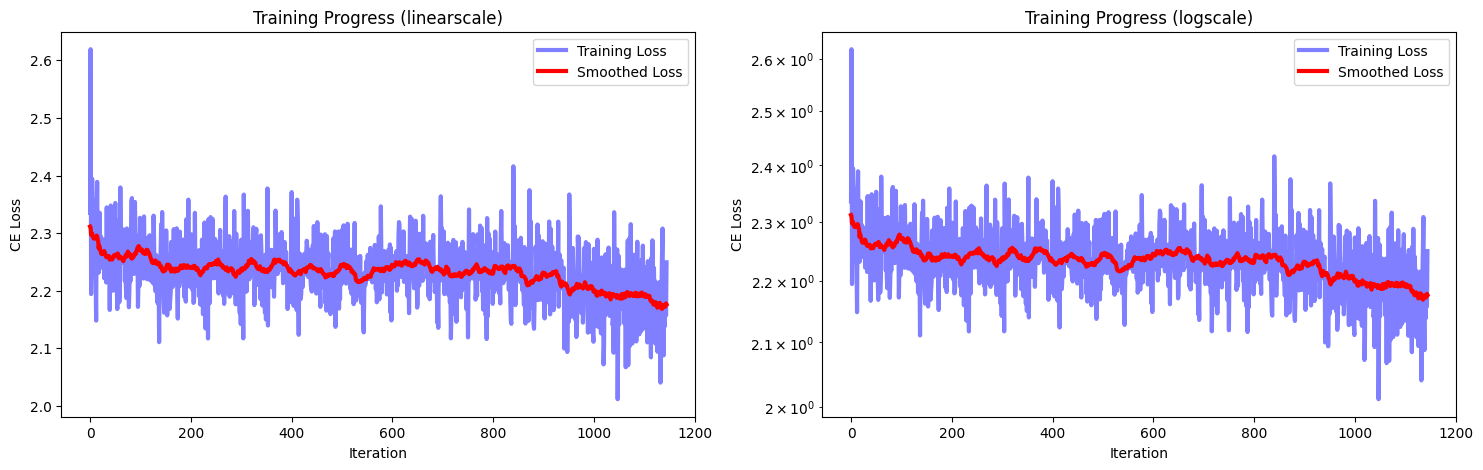

In [13]:
def plot_loss(losses):
    # plt.style.use("seaborn")
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(18, 5)

    smooth_loss = smooth(losses, 31)
    ax[0].plot(losses, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_title("Training Progress (linearscale)")

    ax[1].plot(losses, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
    ax[1].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_yscale("log")
    ax[1].set_title("Training Progress (logscale)")

    plt.show()


plot_loss(losses)